In [1]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter

# from utils import *


C:\Users\jhroe\AppData\Local\Temp\ipykernel_2828\626532668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [25]:
current_directory = os.getcwd()
print(current_directory)
# date = datetime.now().strftime("%Y%m%d")
pi = pd.read_excel('Data/raw/LUAD Clinical Data.xlsx')

# Get current directory
current_directory = os.getcwd()
data_path = current_directory + '/Data/'

# Set path 
df = pd.read_csv(f"{data_path}/clustered/full_cd_clus_20_40_49.csv").rename(columns={'cluster': 'agglomerateto_275'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240313.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID', 'cluster': 'agglomerateto_275'})

# Merge location data 
df= pd.merge(df, df_loc, on='source_ID', how='inner')


c:\Users\jhroe\Desktop\Thesis\Clean\CellularCommunityAnalysisNSCLC\Sorin


In [37]:
data = df[['Patient_ID', 'agglomerateto_40']]
count_data = data.groupby(['Patient_ID', 'agglomerateto_40']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID'])['count'].sum().reset_index(name='total_clus')
count_df = pd.merge(count_data, total_clus, on=['Patient_ID'])

count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df
# count_data

,Patient_ID,agglomerateto_40,count,total_clus,relative_frequency
0,LUAD_D001,1,12,4517,0.002657
1,LUAD_D001,2,3,4517,0.000664
2,LUAD_D001,3,81,4517,0.017932
3,LUAD_D001,4,198,4517,0.043834
4,LUAD_D001,5,1378,4517,0.305070
...,...,...,...,...,...
13251,LUAD_D416,36,7,2879,0.002431
13252,LUAD_D416,37,13,2879,0.004515
13253,LUAD_D416,38,10,2879,0.003473
13254,LUAD_D416,39,177,2879,0.061480


In [41]:
pi.rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=True)
count_df.rename(columns={'agglomerateto_40':'cluster'}, inplace=True)

df_full = pd.merge(count_df, pi, on='Patient_ID', how='inner')
df_full[df_full['cluster']==1]

,Patient_ID,cluster,count,total_clus,relative_frequency,"Sex (Male: 0, Female: 1)","Age (<75: 0, ≥75: 1)","BMI (<30: 0, ≥30: 1)","Smoking Status (Smoker: 0, Non-smoker:1)","Pack Years (1-30: 0, ≥30: 1)","Stage (I-II: 0, III-IV:1)","Progression (No: 0, Yes: 1)",death,survival,"Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)"
0,LUAD_D001,1,12,4517,0.002657,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
35,LUAD_D002,1,62,3121,0.019865,0,0,0,0.0,1.0,0.0,1.0,0,10.111,1
66,LUAD_D003,1,60,3338,0.017975,0,0,0,0.0,1.0,0.0,0.0,1,2.094,5
104,LUAD_D004,1,12,4237,0.002832,0,1,0,0.0,1.0,0.0,0.0,1,1.755,4
134,LUAD_D005,1,51,4300,0.011860,1,0,1,0.0,1.0,0.0,0.0,1,7.598,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13084,LUAD_D412,1,35,4522,0.007740,1,0,1,0.0,0.0,0.0,0.0,0,9.944,3
13117,LUAD_D413,1,39,4480,0.008705,1,0,0,0.0,0.0,0.0,0.0,0,8.132,1
13149,LUAD_D414,1,6,5561,0.001079,1,0,0,0.0,1.0,0.0,0.0,0,8.550,3
13184,LUAD_D415,1,67,2913,0.023000,1,0,0,0.0,1.0,0.0,0.0,1,1.862,3


In [43]:
relevant = df_full[['Patient_ID', 'cluster', 'survival', 'death', 'relative_frequency']]
relevant[relevant['Patient_ID'] == 'LUAD_D001']
# relevant

,Patient_ID,cluster,survival,death,relative_frequency
0,LUAD_D001,1,8.386,1,0.002657
1,LUAD_D001,2,8.386,1,0.000664
2,LUAD_D001,3,8.386,1,0.017932
3,LUAD_D001,4,8.386,1,0.043834
4,LUAD_D001,5,8.386,1,0.305070
5,LUAD_D001,6,8.386,1,0.008413
6,LUAD_D001,7,8.386,1,0.077706
7,LUAD_D001,8,8.386,1,0.015940
8,LUAD_D001,9,8.386,1,0.016604
9,LUAD_D001,11,8.386,1,0.012840


,,cluster,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
Patient_ID,survival,death,,,,,,,,,,,,,,,,,,,,,
LUAD_D001,8.386,1,0.002657,0.000664,0.017932,0.043834,0.305070,0.008413,0.077706,0.015940,0.016604,0.000000,...,0.000664,0.000000,0.017711,0.001328,0.000443,0.002214,0.000221,0.007970,0.010627,0.003985
LUAD_D002,10.111,0,0.019865,0.000641,0.021788,0.068568,0.323614,0.018904,0.069209,0.057994,0.005127,0.000000,...,0.000000,0.000000,0.011855,0.000961,0.000641,0.000000,0.000000,0.008651,0.005447,0.000320
LUAD_D003,2.094,1,0.017975,0.016177,0.016477,0.025165,0.273217,0.006291,0.031456,0.031456,0.022169,0.000300,...,0.008987,0.000000,0.027561,0.004194,0.002996,0.005093,0.002097,0.005692,0.028760,0.001797
LUAD_D004,1.755,1,0.002832,0.000472,0.023838,0.054048,0.282983,0.016049,0.024782,0.011093,0.000708,0.000000,...,0.000236,0.000000,0.009677,0.000236,0.000236,0.000000,0.000236,0.001416,0.008497,0.004012
LUAD_D005,7.598,1,0.011860,0.012558,0.015116,0.011163,0.061395,0.005116,0.014186,0.015581,0.020233,0.019535,...,0.006279,0.000233,0.009535,0.001395,0.003953,0.008140,0.001628,0.013256,0.004419,0.002558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LUAD_D412,9.944,0,0.007740,0.000221,0.061256,0.045555,0.177797,0.022999,0.050199,0.017470,0.007077,0.000000,...,0.000000,0.000000,0.037815,0.001327,0.001769,0.000000,0.000885,0.000663,0.047324,0.004202
LUAD_D413,8.132,0,0.008705,0.000446,0.022545,0.073884,0.338839,0.040625,0.027232,0.008705,0.009152,0.000000,...,0.001563,0.000000,0.012946,0.001339,0.000893,0.000223,0.000000,0.000670,0.024777,0.004464
LUAD_D414,8.550,0,0.001079,0.001798,0.005575,0.033807,0.281244,0.011689,0.003776,0.003237,0.001798,0.002877,...,0.000180,0.000000,0.011689,0.002338,0.000000,0.000180,0.000180,0.001259,0.005395,0.005395


Amount of people with 0 prevalence exactly: 0


Amount of people with 0 prevalence exactly: 0


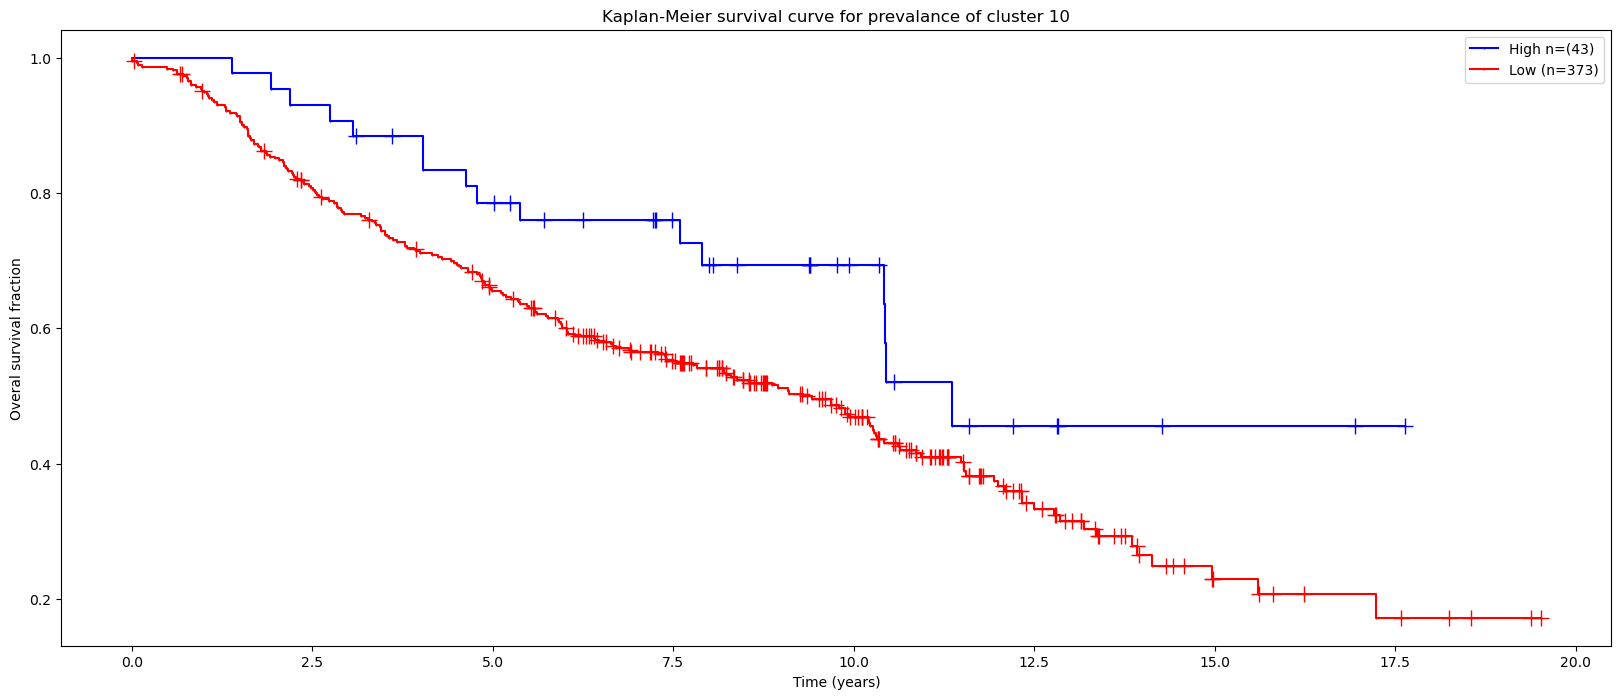

In [74]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 10

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()

Amount of people with 0 prevalence exactly: 0


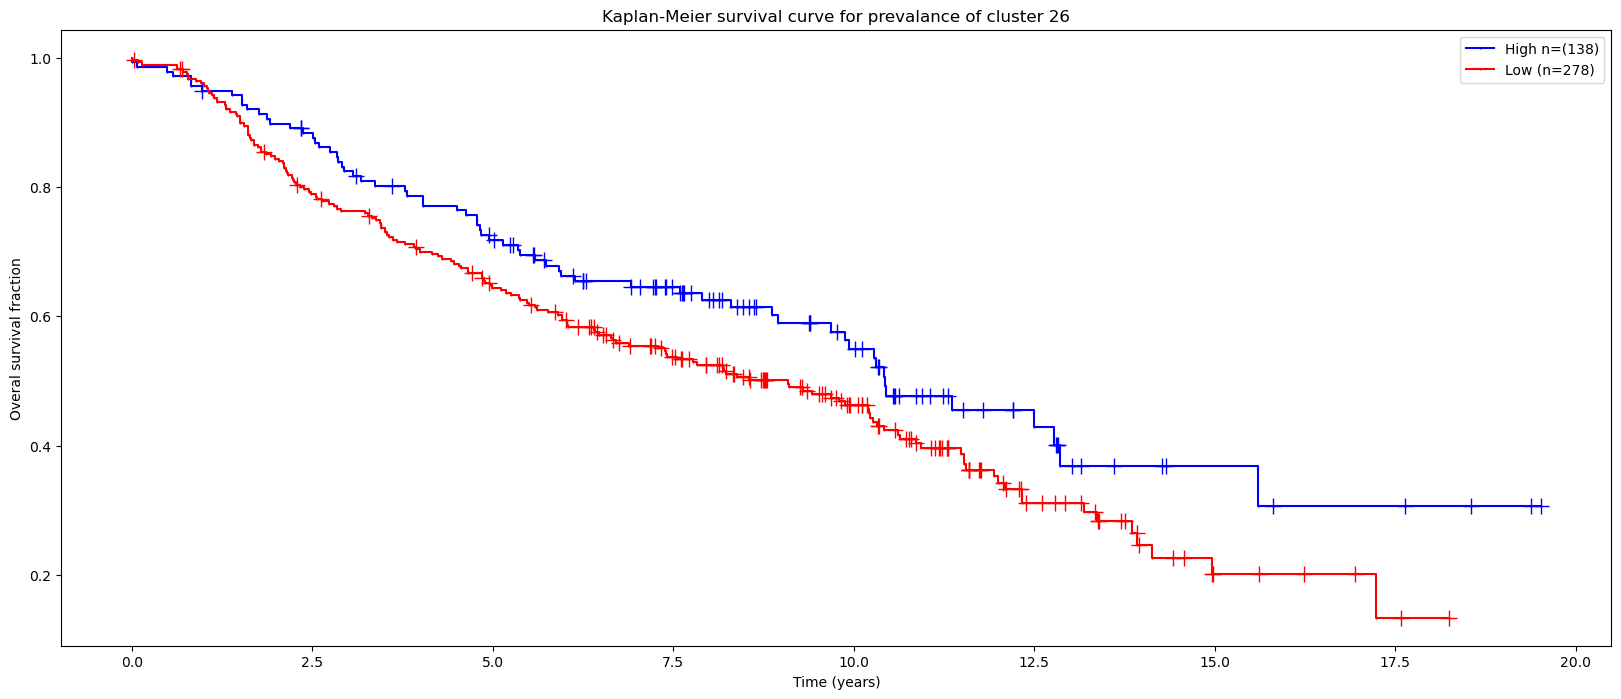

In [75]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()